In [1]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = subclust2(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

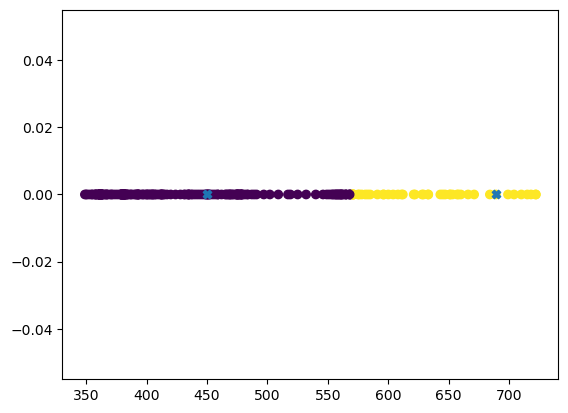

In [81]:
#c1 = np.random.rand(150,2)+[1,1]
#c2 = np.random.rand(100,2)+[10,1.5]
#c3 = np.random.rand(50,2)+[4.9,5.8]

f = open("samplesVDA4.txt", "r")

m = []

for x in f:
  m.append([int(x),0])

    
#m = np.append(c1,c2, axis=0)
#m = np.append(m,c3, axis=0)

m = np.asarray(m, dtype=np.float32)


r,c = subclust2(m,1)

plt.figure()
plt.scatter(m[:,0],m[:,1], c=r)
plt.scatter(c[:,0],c[:,1], marker='X')

In [69]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        print("nivel acti")
        print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        print("sumMu")
        print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()





--- 0.006005287170410156 seconds ---
nivel acti
[[0.87892116 0.06774106]
 [0.87551642 0.06655766]
 [0.8822884  0.06894154]
 [0.89215988 0.07264708]
 [0.90781379 0.07917973]
 [0.93064653 0.09060431]
 [0.96140535 0.11190751]
 [0.99072816 0.14972899]
 [0.99767394 0.21851717]
 [0.95721313 0.31663301]
 [0.87207473 0.43566418]
 [0.75443839 0.56921002]
 [0.62434957 0.70171187]
 [0.50568465 0.81243376]
 [0.40215231 0.89854378]
 [0.31300356 0.95933453]
 [0.24556509 0.99072816]
 [0.19354491 1.        ]
 [0.15647577 0.99355206]
 [0.13278957 0.98075245]
 [0.11918696 0.96917598]
 [0.11918696 0.96917598]
 [0.1268232  0.97611097]
 [0.143199   0.98740116]
 [0.16820915 0.9971291 ]
 [0.20716261 0.9992815 ]
 [0.26148618 0.98490616]
 [0.3276628  0.95054904]
 [0.39804578 0.90167506]
 [0.47023497 0.84327639]
 [0.54180923 0.77984405]
 [0.61055687 0.71509244]
 [0.65643402 0.67010616]
 [0.69273168 0.63353521]
 [0.71952634 0.60595766]
 [0.73274084 0.59216252]
 [0.73711461 0.58756671]
 [0.72835113 0.59675996]
 [

array([0., 0., 0., 0.])

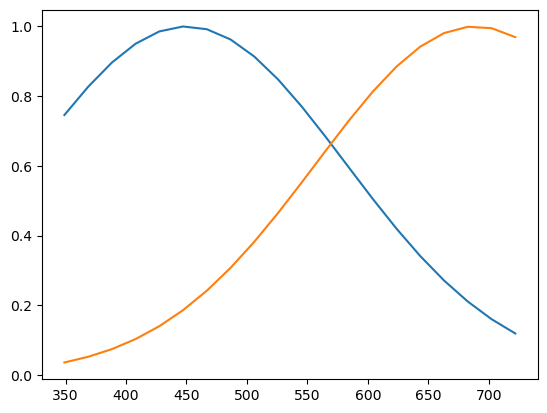

In [82]:
#test genfis 1D
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C



fis2 = fis()
fis2.genfis(m, 1)
fis2.viewInputs()

fis2.solutions

# r1 = data_x*-2.29539539+ -41.21850973
# r2 = data_x*-15.47376916 -79.82911266
# r3 = data_x*-15.47376916 -79.82911266
# plt.plot(data_x,r1)
# plt.plot(data_x,r2)
# plt.plot(data_x,r3)

In [80]:
fis2.rules

array([[450.],
       [689.]], dtype=float32)